In [1]:
#import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow as pa
import seaborn as sns
from datetime import timedelta, datetime

dir = Path(r"S:\Fackler_OSS_364376\data\IRB-364376-v1-230215")

Text(0, 0.5, 'frequency')

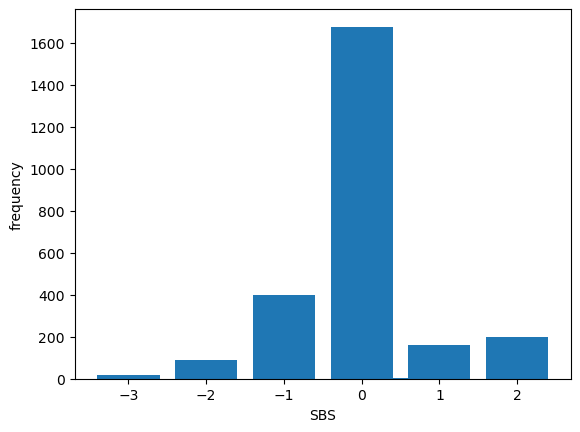

In [2]:
X = np.load('./DONOTPUSH/waveforms_30min.npy')
y = np.load('./DONOTPUSH/sbs_30min.npy')
ids = np.load('./DONOTPUSH/ids_30min.npy')

# shift SBS label: multiclass classifier needs labels to start from 0
labels, counts = np.unique(y, return_counts=True)
plt.bar(labels, counts, align='center')
plt.xlabel('SBS')
plt.ylabel('frequency')

Text(0, 0.5, 'frequency')

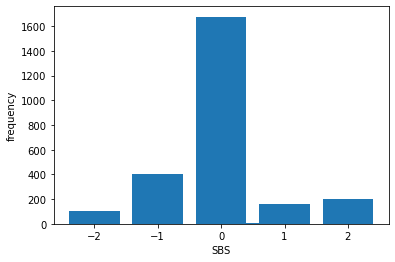

In [4]:
# collabpse SBS = -3
y[y==-3] = -2

labels, counts = np.unique(y, return_counts=True)
plt.bar(labels, counts, align='center')
plt.xlabel('SBS')
plt.ylabel('frequency')

#### Visualize patient data

RR seems to be mostly missing (padded to -1)
SpO2 mostly constant near 100
HR elevated in oversedated?

In [5]:
(undersed,) = np.where(y == 2)
(oversed,) = np.where(y == -2)

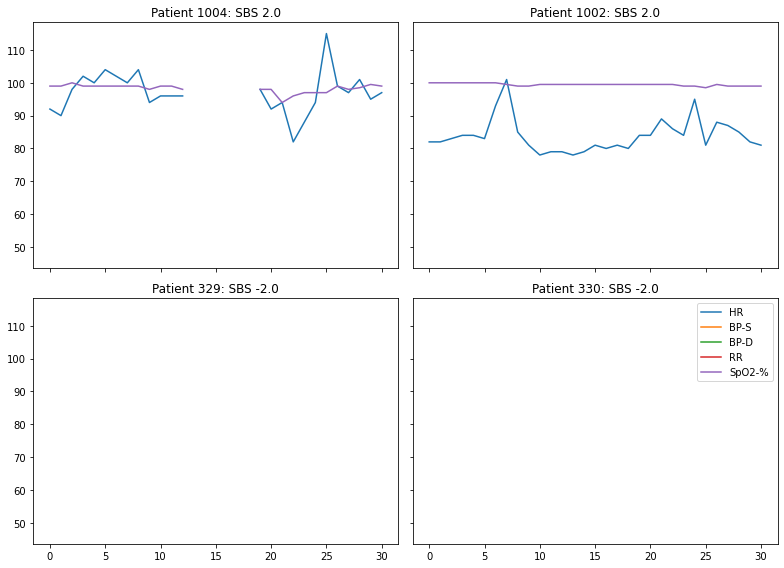

In [9]:
# select patients
samples = [undersed[7], undersed[6], oversed[4], oversed[5]]

# visualize patients
t = np.linspace(0, 30, 31)

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(11, 8))
# 'HR', 'BP-S', 'BP-D', 'RR', 'SPO2-%'

for i, ax in enumerate(axs.flatten()):
    p = samples[i]        
    dat = X[p, :, :]

    # 'dts', 'HR', 'ST-I', 'ST-II', 'ST-III', 'NBP-S', 'NBP-D', 'RR', 'SPO2-%'

    ax.plot(t, dat[0], label='HR')
    ax.plot(t, dat[4], label='BP-S')
    ax.plot(t, dat[5], label='BP-D')
    ax.plot(t, dat[6], label='RR')
    ax.plot(t, dat[7], label='SpO2-%')
    ax.set_title(f'Patient {p}: SBS {y[p]}')
plt.legend()
plt.tight_layout()
plt.show()

Further examine the trends in missing data

In [7]:
X.shape

(2543, 8, 31)

In [14]:
pnan = np.sum(np.sum(np.isnan(X), axis=2), axis=0) / (X.shape[0] * X.shape[2])
pnan

['HR', 'ST-I', 'ST-II', 'ST-III', 'NBP-S', 'NBP-D', 'RR', 'SPO2-%']

array([0.10329431, 0.82484493, 0.82408382, 0.82678574, 0.9715855 ,
       0.9715855 , 0.64689914, 0.09966638])

HR and SpO2% are mostly present, other measures are very sparse

#### ML pipeline

Idea list: https://github.com/danielgy/Paper-list-on-Imbalanced-Time-series-Classification-with-Deep-Learning

In [18]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

from sktime.datasets import load_basic_motions  # multivariate dataset
from sktime.transformations.panel.rocket import Rocket
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [28]:
# select HR and SpO2% only
first = X[:,0,:]
last = X[:,-1,:]
select = np.stack((first, last), axis=1)
select.shape
X = select

(2152, 2, 31)
(391, 2, 31)


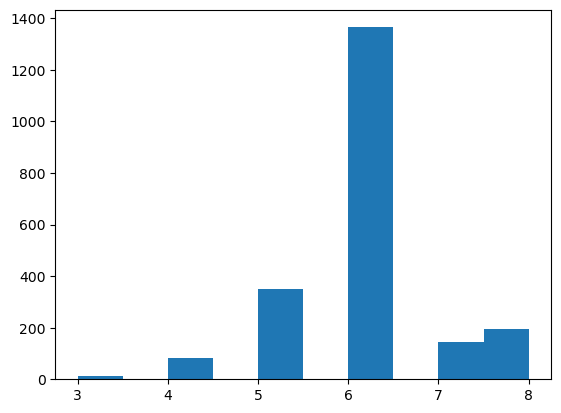

(array([  2.,   0.,   7.,   0.,  50.,   0., 311.,   0.,  15.,   6.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <BarContainer object of 10 artists>)

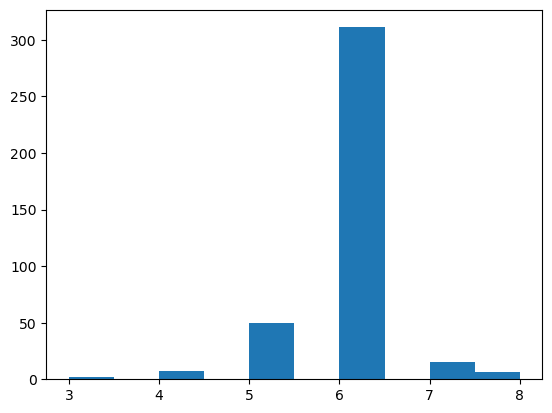

In [42]:
# replace missing data with unphysiological value
X = np.nan_to_num(X, nan=-1)

# shift SBS to range from 0 to 6
y += 2


# preserve class ratio in train and test set
# X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# split by patient instead to reduce bias. 
# n_splits for cross validation
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
split = gss.split(X, y, ids)
train_index, test_index = next(split)

X_train = X[train_index,:,:]
y_train = y[train_index]
X_test = X[test_index,:,:]
y_test = y[test_index]

print(X_train.shape)
print(X_test.shape)

# check class distribution of training and test groups
plt.hist(y_train)
plt.show()
plt.hist(y_test)
# visually, they look similar

Normalize data onto 0-1 range for each physiological parameter.
- Another approach is standardization to 0 mean and 1 std, but here we don't expect physiology to fall onto a normal curve
- This is vulnerable to the test distribution being different from the train distribution in terms of minmax. A obvious flaw is that age is strongly correlated to range of heart rate

In [13]:
from numpy import newaxis
minX = np.min(X_train, axis=(0,2)).reshape(8, 1)[newaxis, :, :]
maxX = np.max(X_train, axis=(0,2)).reshape(8, 1)[newaxis, :, :]
X_train = (X_train - minX) / (maxX - minX)

# note the test dataset is standardized to the min/max of the train set
X_test = (X_test - minX) / (maxX - minX)

##### Addressing class imbalance:
Common strategies for class imbalance are random upsampling and downsampling, as well as synthetic upsampling.
- Random downsampling: remove examples from the most common class. This is not preferred here since we do not have too many data points
- Random upsampling: repeating rare classes
- Synthetic upsampling generates synthetic data using available data distribution. We use [SMOTE](https://arxiv.org/pdf/1106.1813.pdf), a highly-cited algorithm
Importantly, upsampling is only done on the training data

However, the results did not fix classification bias. There is also theoretical work suggesting that for strong classifiers, tuning the threshold is better than SMOTE (https://arxiv.org/abs/2201.08528)

In [ ]:
# randomly upsample rare classes
# sampler = RandomOverSampler(random_state=42)

(15288, 3, 30)


(array([2548.,    0., 2548.,    0., 2548.,    0., 2548.,    0., 2548.,
        2548.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

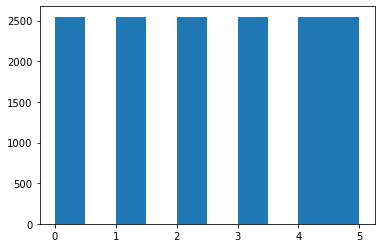

In [129]:

# synthetic upsampling using SMOTE
sampler = SMOTE()

# obtain data array dimensions
samples = X_train.shape[0]
dims = X_train.shape[1]
times = X_train.shape[2]
X_lin = X_train.reshape(samples,-1)

# use SMOTE sampler to generate new data in rare classes
X_oversample, y_train = sampler.fit_resample(X_lin, y_train)
X_train = X_oversample.reshape((X_oversample.shape[0], dims, times))

# visualize outputs
print(X_train.shape)
plt.hist(y_train)

### Models

https://github.com/timeseriesAI/tsai

#### TSai

In [36]:
from tsai.all import *
my_setup()

os              : Windows-10-10.0.19045-SP0
python          : 3.10.11
tsai            : 0.3.7
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 2.0.1+cpu
cpu cores       : 6
threads per cpu : 1
RAM             : 24.0 GB
GPU memory      : N/A


Counts by label: {5.0: 350, 6.0: 1365, 7.0: 145, 4.0: 81, 8.0: 194, 3.0: 14, 6.5: 3}
Naive Accuracy: 63.43%


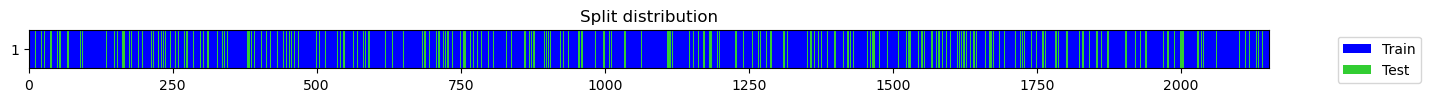

((#1722) [681,1448,747,1677,1186,1172,980,1582,1273,1906...],
 (#430) [61,601,1788,1593,274,1422,90,895,1351,1035...])

In [43]:
label_counts = collections.Counter(y_train)

print('Counts by label:', dict(label_counts))
print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%')

splits = get_splits(y_train, valid_size=.2, stratify=True, random_state=23, shuffle=True)
splits

In [44]:
tfms  = [None, TSClassification()] # TSClassification == Categorize
batch_tfms = TSStandardize()

dls = get_ts_dls(X_train, y_train, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
dls.vocab, dls.train.cws

([3.0, 4.0, 5.0, 6.0, 6.5, 7.0, 8.0],
 TensorCategory([0.1980, 0.0335, 0.0078, 0.0020, 0.7259, 0.0188, 0.0141]))

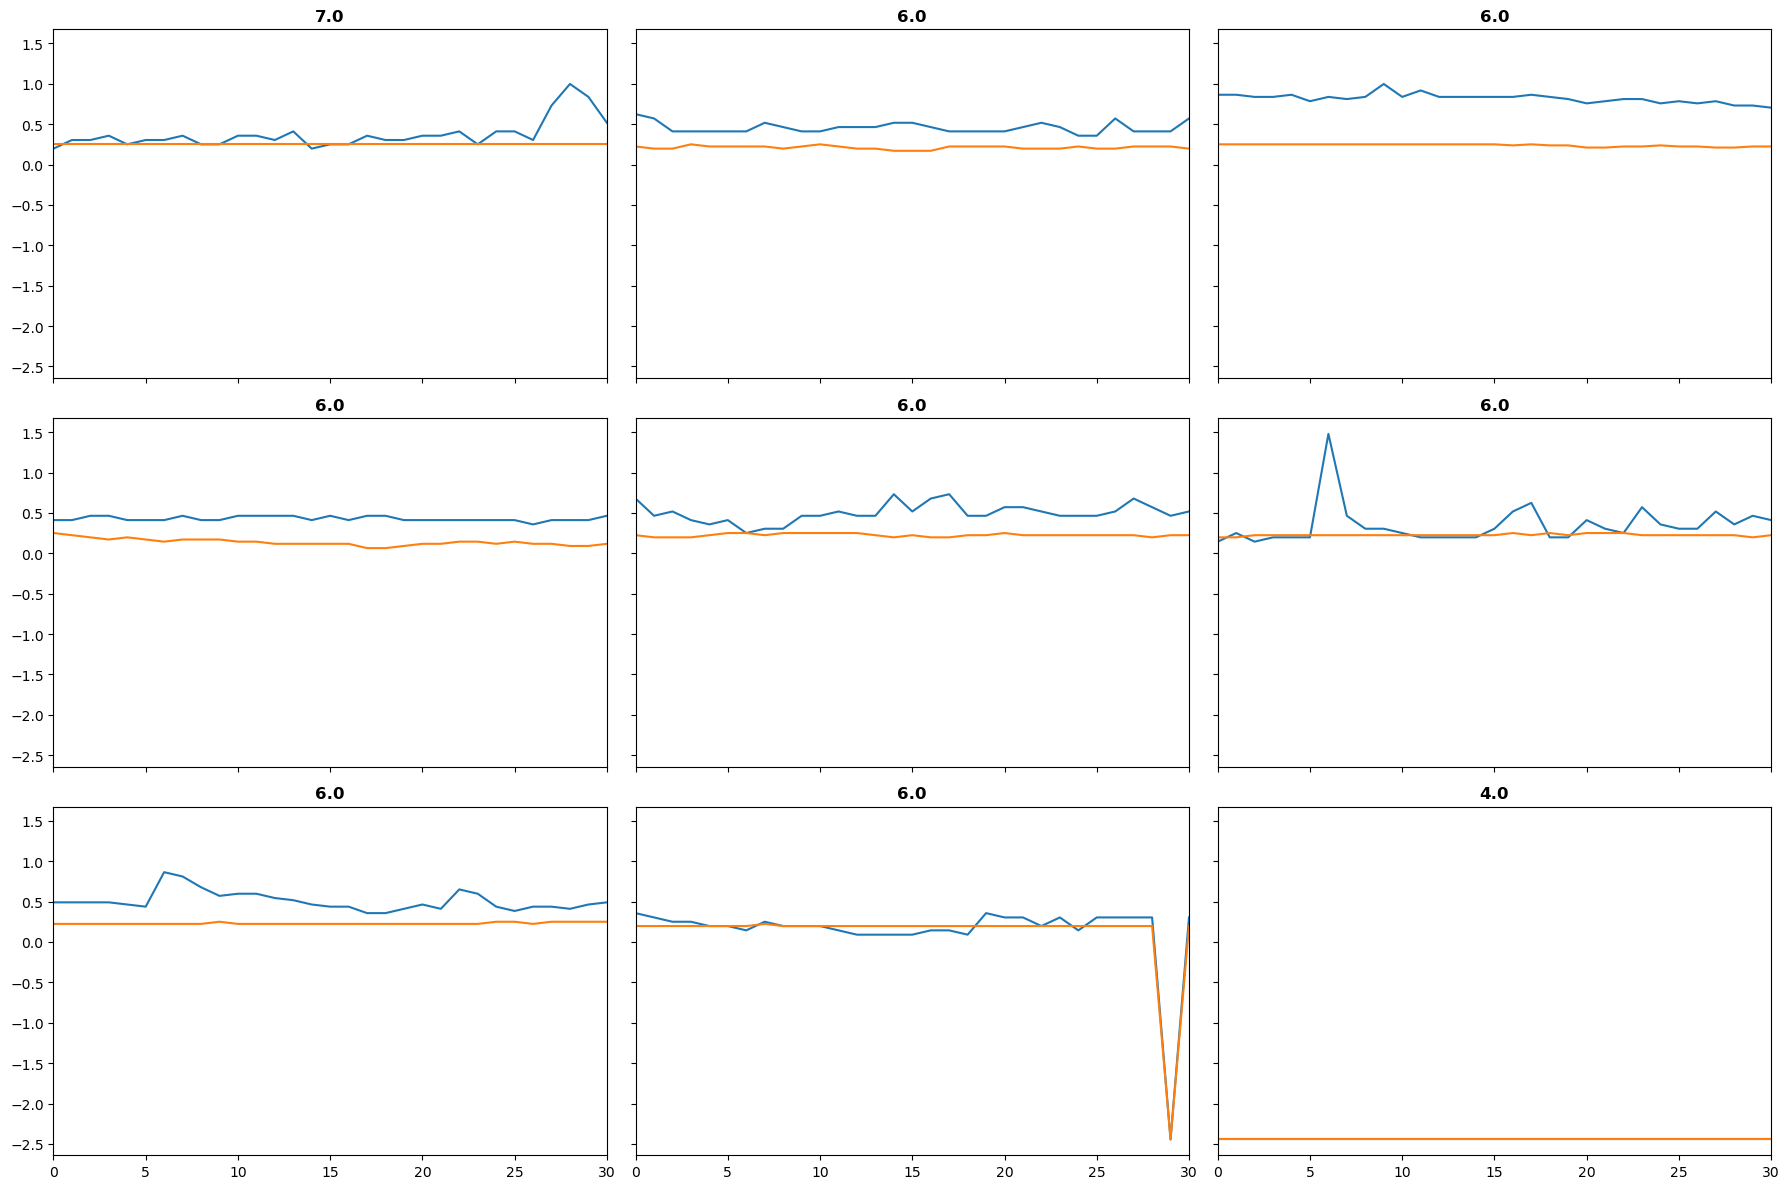

In [45]:
dls.show_batch(sharey=True)

SuggestedLRs(valley=0.001737800776027143)

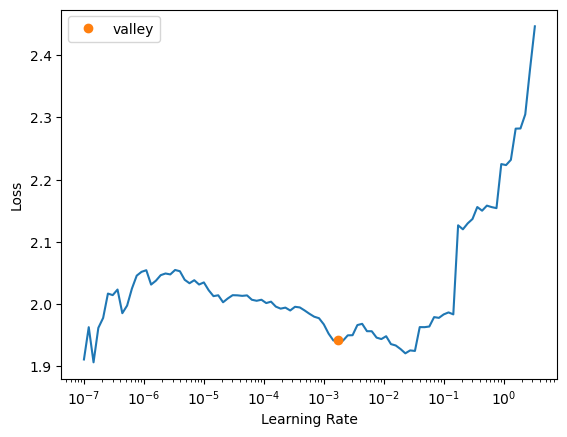

In [46]:
# model = build_ts_model(InceptionTimePlus, dls=dls)
metrics = [accuracy]
learn = ts_learner(dls, InceptionTimePlus, metrics=metrics, loss_func=CrossEntropyLossFlat(weight=dls.train.cws))

learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.881847,1.887092,0.190698,00:06
1,1.684598,1.553869,0.602326,00:05
2,1.494352,1.300229,0.586047,00:05
3,1.347076,1.185500,0.616279,00:05
4,1.249322,1.158691,0.611628,00:05
5,1.191727,1.175846,0.634884,00:05
6,1.146390,1.130344,0.639535,00:05
7,1.127807,1.121719,0.625581,00:05
8,1.104251,1.109280,0.632558,00:05
9,1.081558,1.191676,0.613953,00:05


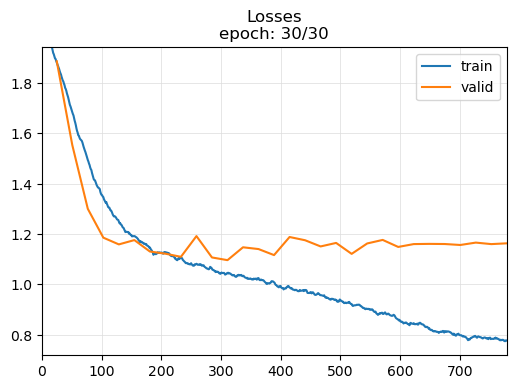

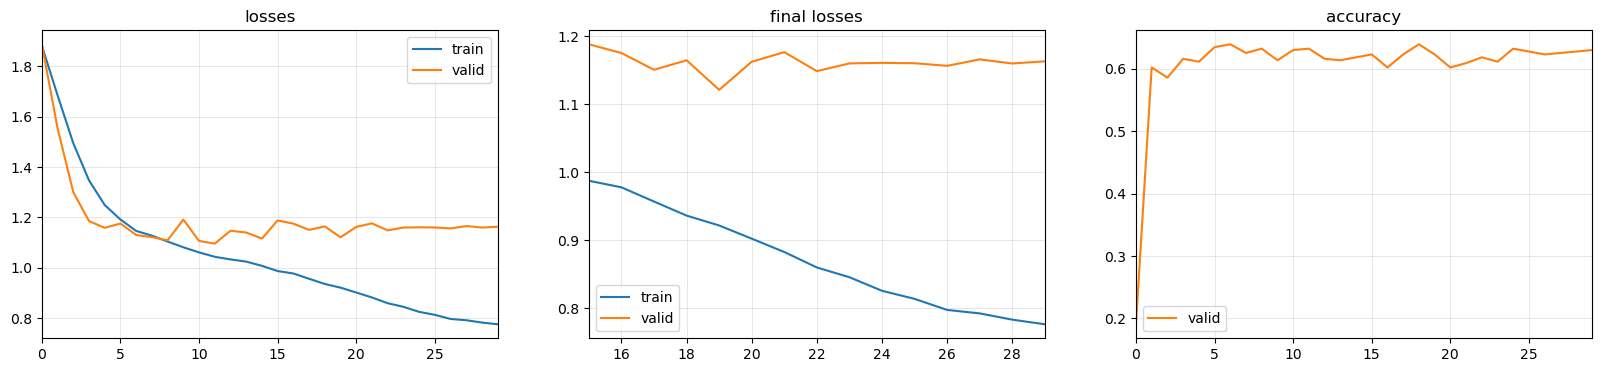

In [48]:
# train
learn = ts_learner(dls, metrics=accuracy, cbs=ShowGraph())
learn.fit_one_cycle(30, lr_max=0.0005)

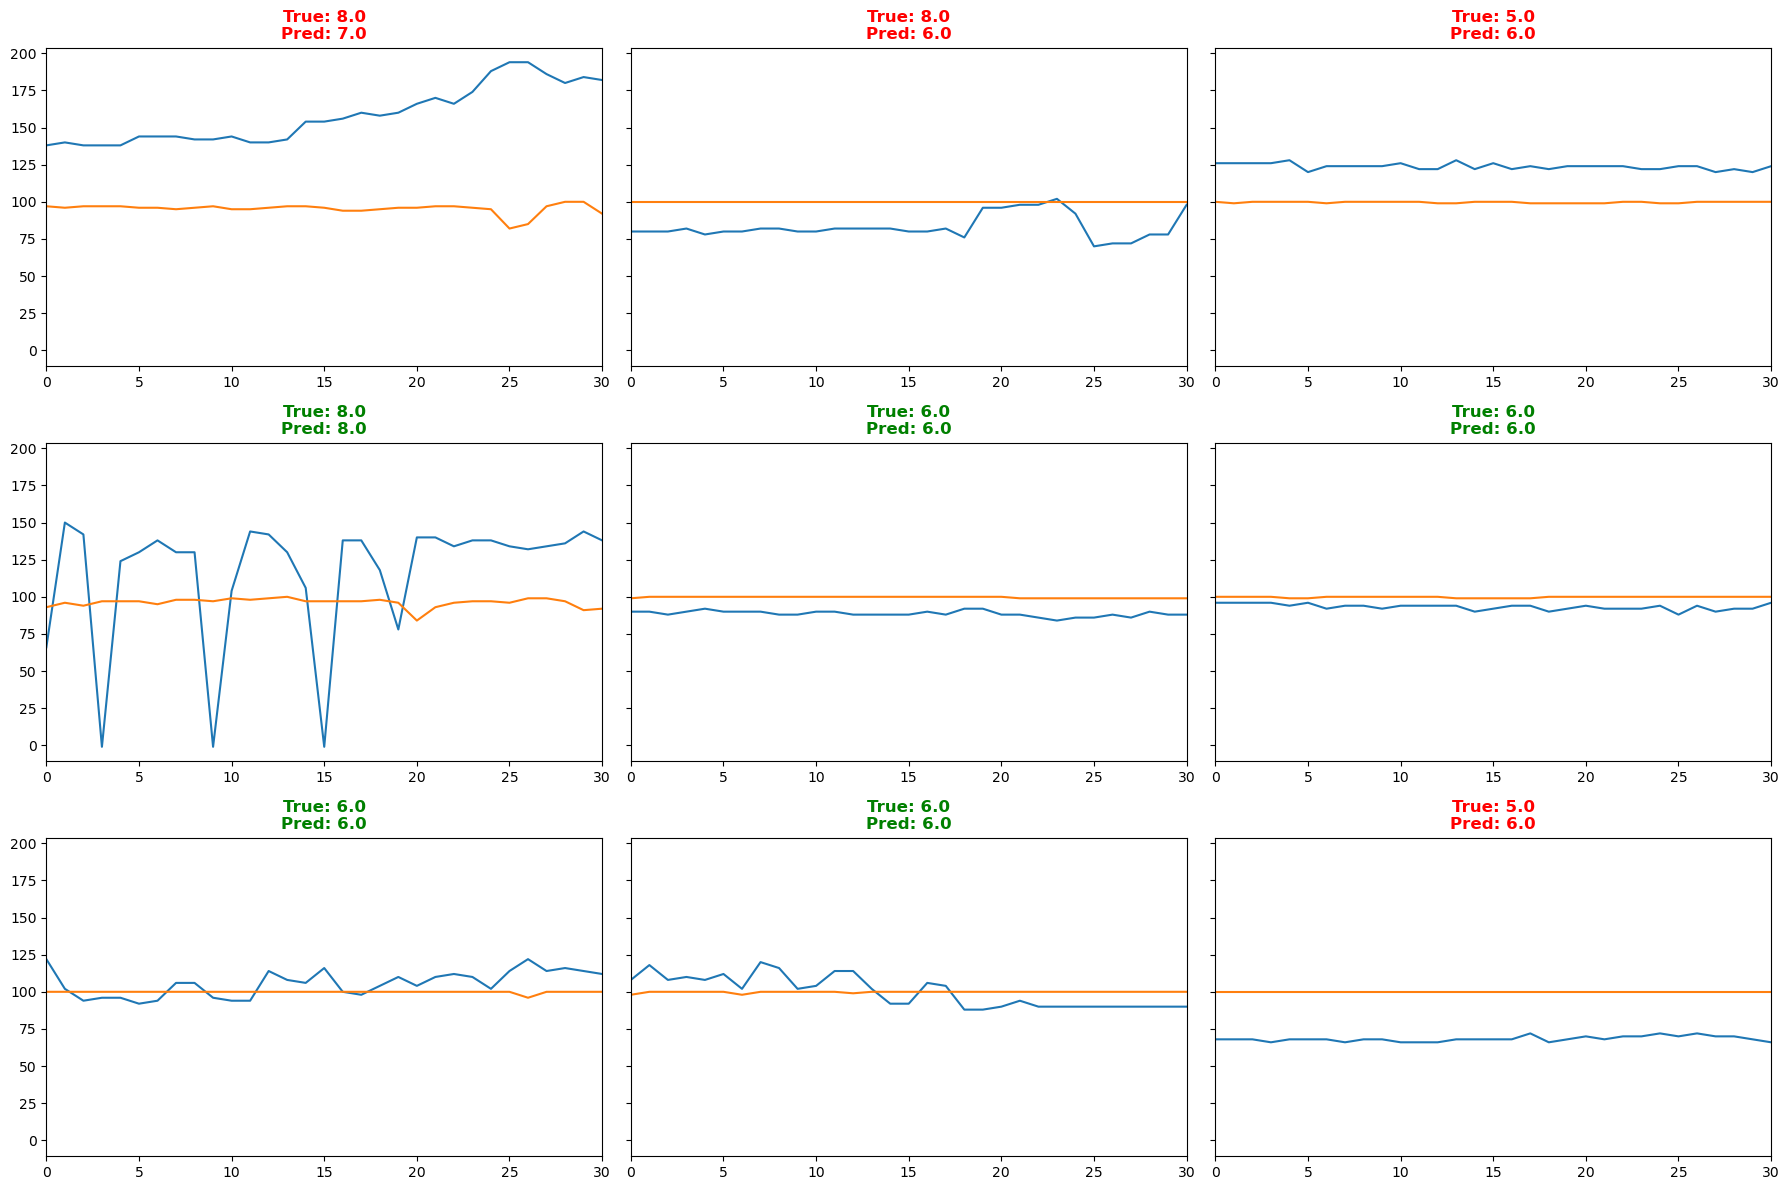

In [49]:
learn.show_results(sharey=True)

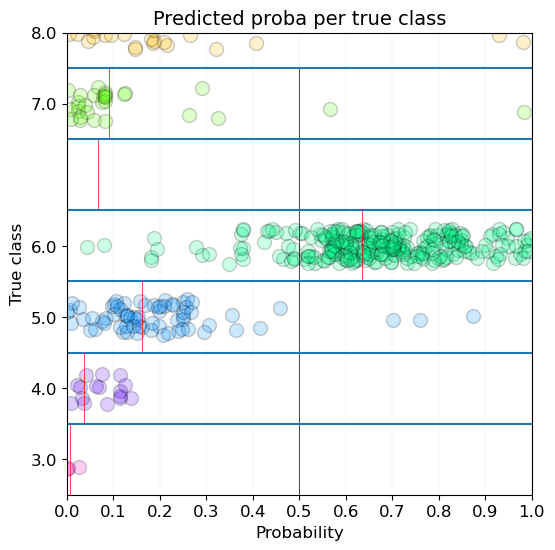

In [50]:
learn.show_probas()

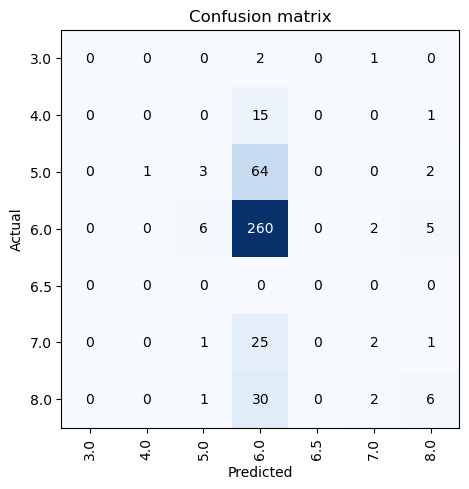

In [51]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### ROCKET + XGBoost:
- [Workflow tutorial](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)
- [Hyperparameter list](https://xgboost.readthedocs.io/en/stable/parameter.html)

- [Hyperparameter tuning tutorial (Section 2)](https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663)

An alternative to upsampling is to weigh samples by class rarity

In [178]:
rocket = Rocket()
rocket.fit(X_train)
# transform patient waveform into features using ROCKET
X_train_transform = rocket.transform(X_train)
X_test_transform = rocket.transform(X_test)

In [181]:
# use xgboost to process time series features
dtrain = xgb.DMatrix(X_train_transform, label=y_train)
dtest = xgb.DMatrix(X_test_transform, label=y_test)
evallist = [(dtrain, 'train'), (dtest, 'eval')]
evalset = [(X_train_transform, y_train), (X_test_transform, y_test)]

param = {'n_estimators': 15,
         'max_depth': 10, 
         'learning_rate': 0.2,          # try 0.01, 0.1, and 1 first
         'colsample_bytree': 1,
         'subsample': 0.9,
         'gamma': 10,
         'objective': 'multi:softmax', 
         'num_class': 6,
         'eval_metric': 'auc'}

# https://towardsdatascience.com/how-to-handle-multiclass-imbalanced-data-say-no-to-smote-e9a7f393c310
# add class weight penalty to balance learning from errors made across all classes
class_weight = class_weight.compute_class_weight(class_weight ='balanced', classes=np.unique(y_train), y=y_train)

# double * to unpack param
model = xgb.XGBClassifier(**param)
model.fit(X_train_transform, y_train, eval_set=evalset)


# bst = xgb.train(param, dtrain, num_round, evallist)

# observe that as train AUC increase, eval AUC decrease
# this indicates model overfitting (or the data is fundamentally different)
# more model tuning is required

[0]	validation_0-auc:0.83505	validation_1-auc:0.57232
[1]	validation_0-auc:0.87962	validation_1-auc:0.59065
[2]	validation_0-auc:0.89504	validation_1-auc:0.60433
[3]	validation_0-auc:0.91117	validation_1-auc:0.61132
[4]	validation_0-auc:0.91998	validation_1-auc:0.61832
[5]	validation_0-auc:0.92222	validation_1-auc:0.61946
[6]	validation_0-auc:0.92585	validation_1-auc:0.62570
[7]	validation_0-auc:0.92840	validation_1-auc:0.62551
[8]	validation_0-auc:0.93166	validation_1-auc:0.62545
[9]	validation_0-auc:0.93310	validation_1-auc:0.62950
[10]	validation_0-auc:0.93738	validation_1-auc:0.63211
[11]	validation_0-auc:0.93849	validation_1-auc:0.63298
[12]	validation_0-auc:0.94082	validation_1-auc:0.63169
[13]	validation_0-auc:0.94213	validation_1-auc:0.63193
[14]	validation_0-auc:0.94531	validation_1-auc:0.63290


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=10, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=15, n_jobs=0,
              num_class=6, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=0, ...)

Accuracy: 0.579


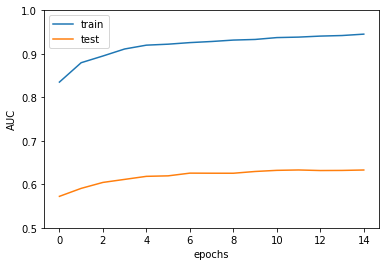

In [184]:
# evaluate performance
yhat = model.predict(X_test_transform)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# we can save this into a list, or plot it

# plot learning curves
plt.plot(results['validation_0']['auc'], label='train')
plt.plot(results['validation_1']['auc'], label='test')
plt.xlabel('epochs')
plt.ylabel('AUC')
# plot from 0 to 1
plt.ylim(0.5,1)
# show the legend
plt.legend()
# show the plot
plt.show()

#### Eval

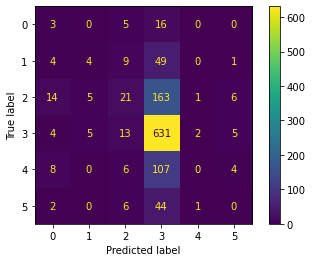

In [185]:
y_class = np.unique(y)
cm = confusion_matrix(y_test, yhat, labels=y_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_class)
disp.plot()